# Group 004 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [1]:
# !mkdir data
# !kaggle datasets download mrdaniilak/russia-real-estate-20182021
# !mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

In [2]:
# import zipfile
# with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
    # zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [5]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
3824523,4800000,2020-06-01,21:42:04,56.280668,43.991727,2871,3,6,9,3,64.0,9.0,1
5352558,7650000,2021-04-18,13:57:16,55.438932,37.570348,81,1,3,17,1,46.0,14.0,1
5310999,16200000,2021-04-09,10:42:21,55.017899,82.939573,9654,3,10,16,3,106.0,25.8,1
2806881,2650000,2019-10-31,02:25:53,45.088250,39.004078,2843,3,4,6,2,51.0,12.0,1
3216693,2910000,2020-02-01,06:44:48,57.177096,65.644903,3991,1,8,10,1,34.8,9.0,1


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

In [6]:
MOSCOW_CODE = 81

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(4, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# Rubles to USD
moscow_df['price'] = moscow_df['price'].apply(lambda x: x * 0.012)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 1000]
moscow_df = moscow_df[moscow_df['price'] <= 2e5]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]

In [7]:
moscow_df.isnull().values.any()

False

In [8]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
821141,33923.712,2018,monolithic,5,6,1,38.4,16.9,new
2180649,40200.000,2019,panel,7,9,2,53.0,9.0,preowned
5330776,20400.000,2021,panel,2,5,2,46.5,9.2,preowned
3122150,43800.000,2020,panel,7,10,3,67.0,9.0,preowned
3287969,27000.000,2020,panel,4,5,1,31.0,6.0,preowned


# Exploration

First, we'll look at the data distributions for the ordinal data.

In [9]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,498204.000000,498204.000000,498204.000000,498204.000000,498204.000000,498204.000000,498204.000000
mean,56278.074684,2019.309183,7.047214,12.737166,1.776074,51.401535,10.324267
std,28025.716730,0.879615,5.709869,7.389051,0.856382,22.934259,5.747438
min,1098.960000,2018.000000,1.000000,1.000000,0.000000,1.000000,0.050000
25%,36000.000000,2019.000000,3.000000,5.000000,1.000000,38.000000,7.000000
50%,51600.000000,2019.000000,5.000000,12.000000,2.000000,46.000000,9.600000
75%,71267.100000,2020.000000,10.000000,17.000000,2.000000,61.800000,12.000000
max,199978.800000,2021.000000,36.000000,39.000000,9.000000,5000.000000,1500.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers. We will also plot regression lines for each to quantify per-variable correlation strength.

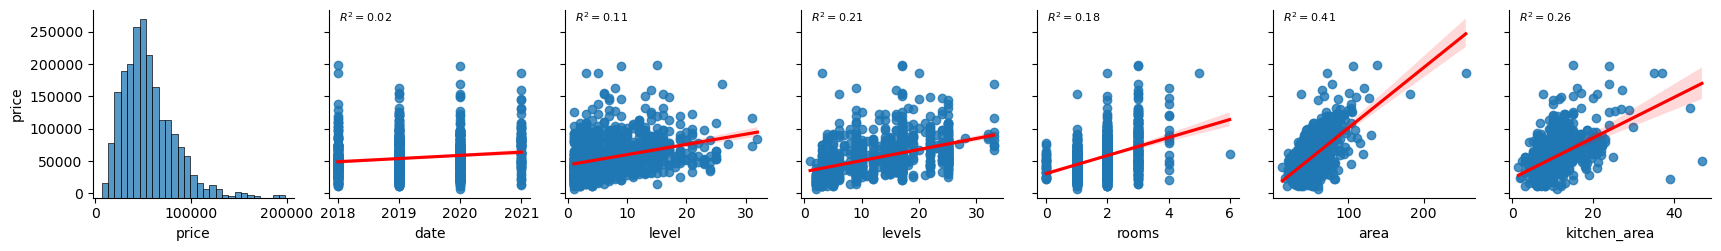

In [11]:
from scipy.stats import linregress

def calc_R2(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$R^2 = {r_value ** 2:.2f}$', xy=(.05, 1), xycoords=ax.transAxes, fontsize=8, ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000), kind='reg', y_vars=['price'], plot_kws={'line_kws':{'color':'red'}})

g.map_upper(calc_R2)
plt.show()

Data and level have near-zero correlations. The number of levels in the building (i.e. building size) and number of rooms, as well have kitchen area, seem like te might have some signidicance. The most important (single) variable seems to be area. However, even here we don't have a strong correlation. Hopefully combining these variables into a multivariate regression will lead to stronger correlation.

Additionally, all of the correlations seem to be closest to linear (as opposed to some polynomial fit). So, a polynomial regression may not perform better than a linear regression.

However, in the above we only use about 1000 samples (for efficiency). We can see these correlation results across the dataset more easily with a heatmap:

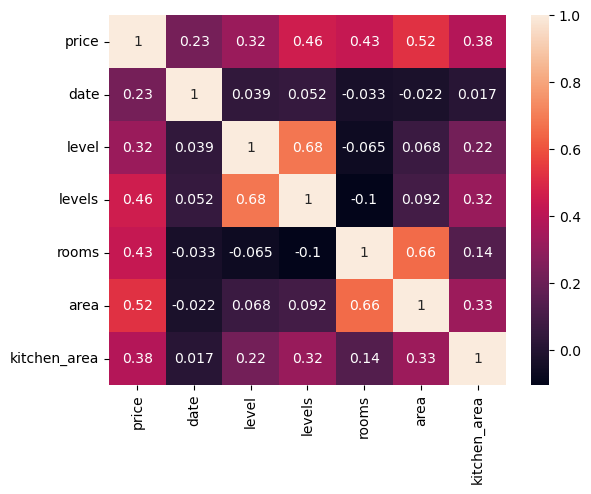

In [12]:
sns.heatmap(moscow_df.drop(['building_type', 'object_type'], axis=1).corr(), annot=True)
plt.show()

Notably, `date` and `level` have a stronger correlation than from our 1000 samples, but each individual variable still does not have a strong enough correlation for prediction.

Thus, we proceed to fitting some models.

## Model Fitting

In [13]:
from sklearn.model_selection import train_test_split

X = moscow_df[['building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = moscow_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'{len(y_train)} train samples; {len(y_test)} test samples')

348742 train samples; 149462 test samples


Now, we will one-hot the categorical data using sklearn's one hot encoder.

In [14]:
from sklearn.preprocessing import OneHotEncoder

for col in ['building_type', 'object_type']:

    one_hot = OneHotEncoder()
    one_hot.fit(X_train[[col]])

    X_train.loc[:, one_hot.categories_[0]] = one_hot.transform(X_train[[col]]).todense()
    X_test.loc[:, one_hot.categories_[0]] = one_hot.transform(X_test[[col]]).todense()

    X_train = X_train.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

X_train.sample(5)

,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
3760708,9,14,3,82.0,11.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2953523,14,25,1,41.0,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1779449,5,9,1,32.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1444872,14,25,2,60.7,10.6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2255106,4,9,1,33.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Next, we will scale the data. Note that not all models require scaled data; while models like linear regression require scaling to avoid overemphasis of certain datapoints, models like descision trees (and, by extension, random forests) are not affected by unscaled variables.

It is also important to note that scaled data won't *negatively* impact descision trees, but we make a copy of scaled data to more explicitly demonstrate model understanding.

In [15]:
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['level', 'levels', 'rooms', 'area', 'kitchen_area']
X_train_ordinal, X_test_ordinal = X_train[ordinal_cols], X_test[ordinal_cols]

scaler = StandardScaler()
scaler.fit(X_train_ordinal)

X_train_scaled, X_test_scaled = X_train, X_test

X_train_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_ordinal)
X_test_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_ordinal)

X_train_scaled.sample(5)

,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
4830475,4.017413,2.472083,1.430537,0.825273,0.946195,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
380794,-0.883952,0.576822,-0.907118,-0.238917,-0.039000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4014028,-0.008708,-0.641560,1.430537,1.893907,-0.413124,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5395832,-0.883952,0.576822,-0.907118,0.027686,0.388571,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1460687,-0.883952,1.659829,1.430537,0.583109,-0.751618,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [16]:
MAX_EPOCHS = 100000

### Linear Regression

Note that SckiKit doesn't offer MAE loss for its `LinearRegression` implementation. However, `linear_model.SGDRegressor` can be made to use an MAE loss by using `epsilon_insensitive` loss and setting its $\epsilon$ hyperparam to $0$.

Note that this does mean we will be using SGD for descent, so our model will take more steps to converge and loss won't strcitly decrease, but in our case using SGD will actually be helpful since our dataset is relatively large, so each epoch will be much faster.

In [17]:
from sklearn.linear_model import SGDRegressor

linreg_mae_model = SGDRegressor(loss='epsilon_insensitive', epsilon=0, max_iter=MAX_EPOCHS, verbose=0)

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import pickle

# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models to train
models = {
    "Linear Regression": linreg_mae_model,
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoosting": XGBRegressor(n_estimators=100, learning_rate=0.05)
}

In [19]:
# # Model training and performance evaluation
# for model_name, model in models.items():
#     # Cross validation
#     cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
#     cv_scores = -cv_scores  # Flip sign to get positive MAE scores
#     print(f'Cross-validation MAE scores (5-fold) for {model_name}: {cv_scores}')
#     print(f'Average CV MAE score for {model_name}: {np.mean(cv_scores)}')
    
#     # Fitting model on train data
#     model.fit(X_train, y_train)
    
#     # Predictions
#     train_preds = model.predict(X_train)
#     test_preds = model.predict(X_test)
    
#     # Calculating MAE
#     train_mae = mean_absolute_error(y_train, train_preds)
#     test_mae = mean_absolute_error(y_test, test_preds)
    
#     # Save model
#     filename = model_name + ".sav"
#     pickle.dump(model, open(filename, 'wb'))
    
#     print(f'Training MAE for {model_name}: {train_mae}')
#     print(f'Testing MAE for {model_name}: {test_mae}')
#     print("\n")
    
#     # Plotting actual vs predicted prices
#     plt.figure(figsize=(8, 6))
#     sns.regplot(x=y_test, y=test_preds, scatter_kws={'alpha':0.3})
#     plt.xlabel('Actual Prices')
#     plt.ylabel('Predicted Prices')
#     plt.title(f'Actual vs Predicted Prices: {model_name}')
#     plt.show()

Linear Regression: 0.3073024591450495
Cross-validation MAE scores (5-fold) for Linear Regression: [16745.44245915 16842.57456169 16740.71211201 16835.16349487
 16842.91281971]
Average CV MAE score for Linear Regression: 16801.361089484642
Training MAE for Linear Regression: 16799.80871923761
Testing MAE for Linear Regression: 16893.053972066897




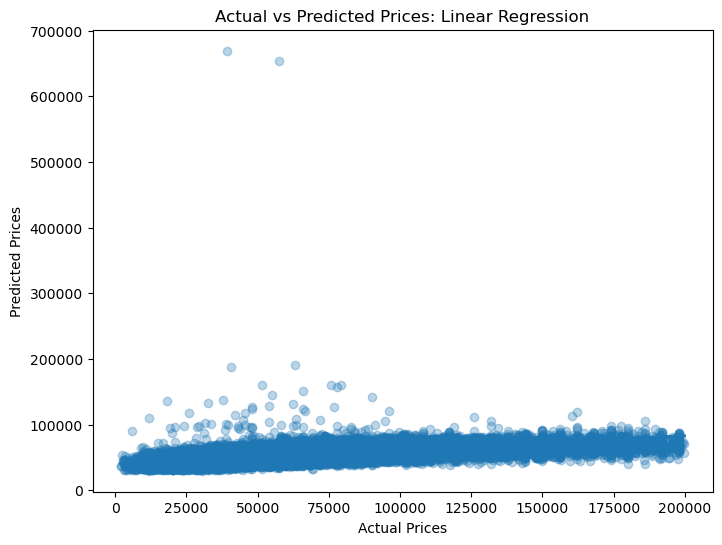

Random Forest: 0.6903102946092627
Cross-validation MAE scores (5-fold) for Random Forest: [10899.29905798 10919.33694157 10928.05177936 10892.44785222
 10876.09137354]
Average CV MAE score for Random Forest: 10903.045400934365
Training MAE for Random Forest: 5668.247755822005
Testing MAE for Random Forest: 10741.167866465428




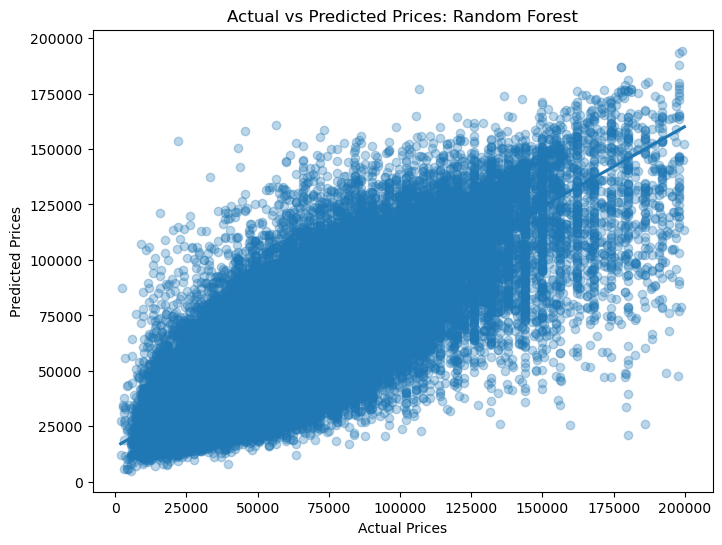

Gradient Boosting: 0.6214534742906521
Cross-validation MAE scores (5-fold) for Gradient Boosting: [12840.5274058  12869.60008955 12846.84645882 12816.77738363
 12783.12596488]
Average CV MAE score for Gradient Boosting: 12831.375460535499
Training MAE for Gradient Boosting: 12796.381494507628
Testing MAE for Gradient Boosting: 12806.55597160173




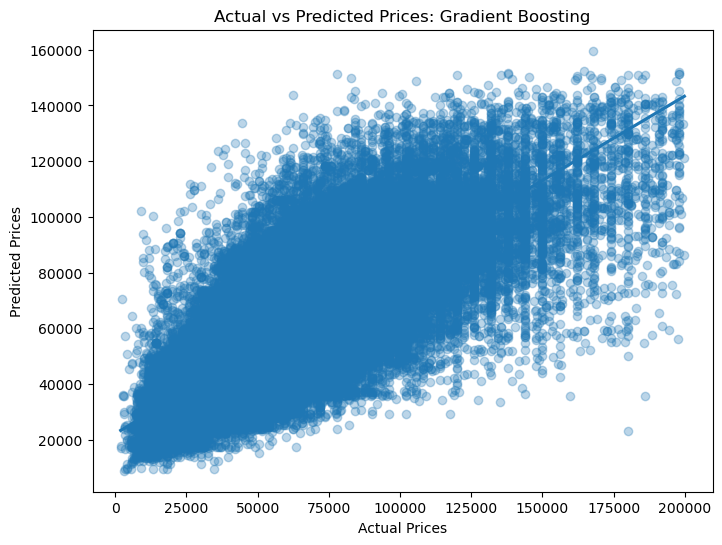

XGBoosting: 0.6381664414187428
Cross-validation MAE scores (5-fold) for XGBoosting: [12456.29095523 12478.93530776 12442.78725935 12439.10836637
 12398.08302535]
Average CV MAE score for XGBoosting: 12443.040982813875
Training MAE for XGBoosting: 12387.545643561627
Testing MAE for XGBoosting: 12431.646178787922




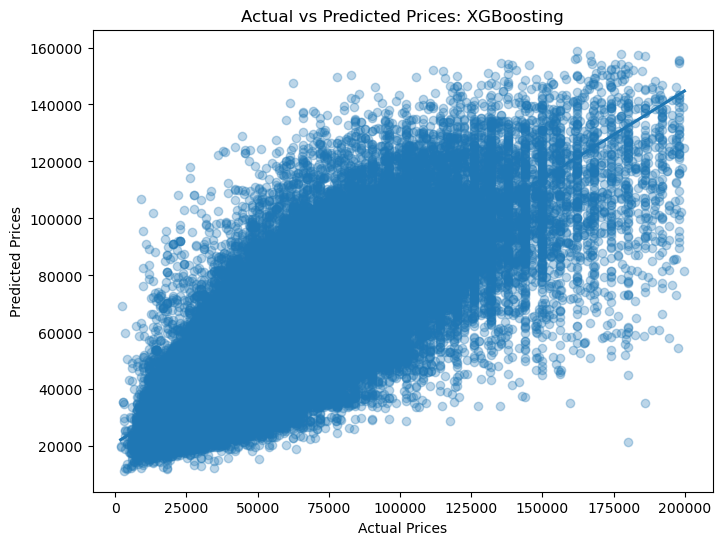

In [20]:
for model_name, model in models.items():
    
    loaded_model = pickle.load(open(model_name + ".sav", 'rb'))
    result = loaded_model.score(X_test, y_test)
    print(model_name + ": " + str(result))
    
    # Fitting model on train data
    loaded_model.fit(X_train, y_train)
    
    # Predictions
    train_preds = loaded_model.predict(X_train)
    test_preds = loaded_model.predict(X_test)
    
    # Cross validation
    cv_scores = cross_val_score(loaded_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_scores = -cv_scores  # Flip sign to get positive MAE scores
    print(f'Cross-validation MAE scores (5-fold) for {model_name}: {cv_scores}')
    print(f'Average CV MAE score for {model_name}: {np.mean(cv_scores)}')
    
    # Calculating MAE
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    
    print(f'Training MAE for {model_name}: {train_mae}')
    print(f'Testing MAE for {model_name}: {test_mae}')
    print("\n")
    
    # Plotting actual vs predicted prices
    plt.figure(figsize=(8, 6))
    sns.regplot(x=y_test, y=test_preds, scatter_kws={'alpha':0.3})
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs Predicted Prices: {model_name}')
    plt.show()
